<a href="https://colab.research.google.com/github/vincm1/UK_accidents/blob/main/Final_assignment_Big_Data_for_Decision_Making_(2021_22_BNK432_NO02_A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final assignment - Big Data for Decision Making (2021-22 BNK432_NO02_A)**

In [93]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("UK Road Accidents 2018.csv")
df.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban


## **1)** **Business** **objective and context**

The above seen dataset is published by the UK Department for Transport and is published sinced 1978. For this report, a snippet of the data is taken and handles all UK road accidents that happened in 2018 on an hourly level. Furthermore, it shows which day of the week it has been, the condition of precipitation within that time as well as whether there was high wind. Moreover, the dataset contains information about the road surface conditions, light conditions and in what kind of area the accidents in that hour happened.

The goal of this report is to forecast the number of hourly accidents occuring on UK streets for Britannia Rescue in order to help its rescourcing planning by an appropriate forecasting model.

To predict the numbers the following report structure will be included. First, the data will explored and preprocessed. Secondly, the features are selected and a baseline model will be drawn. Thirdly, models will be trained, hyperparameters tuned and thereby evaluated, which model shows the best performance for predicting road accidents for the client. To sum up, the results will be discussed and further steps will be introduced.

### Data inspection 

In [3]:
df.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area'],
      dtype='object')

In [4]:
df.shape

(8540, 8)

In [5]:
df.describe()

,Count
count,8540.000000
mean,14.358548
std,10.479488
min,1.000000
25%,5.000000
50%,13.000000
75%,21.000000
max,62.000000


In [6]:
df.dtypes

datetime                   object
Count                       int64
Day_of_Week                object
Precipitation              object
High_Winds                   bool
Road_Surface_Conditions    object
Light_Conditions           object
Urban_or_Rural_Area        object
dtype: object

Creating more granularity in the date info

In [7]:
df["datetime"] = pd.to_datetime(df["datetime"])

In [8]:
df["day"] = df["datetime"].dt.date
df["day"] = pd.to_datetime(df["day"])

In [9]:
df["day_n"] = df["datetime"].dt.day

In [10]:
df["hour"] = df["datetime"].dt.hour

In [11]:
df["month"] = df["datetime"].dt.month_name()

In [12]:
df["month_n"] = df["datetime"].dt.month

In [13]:
df.loc[(df['Day_of_Week'] == 'Saturday') | (df['Day_of_Week'] == 'Sunday'), 'Weekend'] = 'Weekend'
df.loc[(df['Day_of_Week'] != 'Saturday') & (df['Day_of_Week'] != 'Sunday'), 'Weekend'] = 'Weekday'  

In [14]:
conditions_season = [
                     ((df["month"] == "December") | (df["month"] == "January") | (df["month"] == "February")),
                     ((df["month"] == "March") | (df["month"] == "April") | (df["month"] == "May")),
                     ((df["month"] == "June") | (df["month"] == "July") | (df["month"] == "August")),
                     (df["month"] == "September") | (df["month"] == "October") | (df["month"] == "November")
]

values_season = ["Winter","Spring","Summer","Autumn"]

df["Season"] = np.select(conditions_season, values_season)

In [15]:
cat_names = ['Day_of_Week', 'Weekend','Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'month','Weekend','Season','hour']
print("Unique count of categorical features:")
for i in cat_names:
  print(i,df[i].unique().size)

Unique count of categorical features:
Day_of_Week 7
Weekend 2
Precipitation 7
High_Winds 2
Road_Surface_Conditions 6
Light_Conditions 5
Urban_or_Rural_Area 2
month 12
Weekend 2
Season 4
hour 24


In [16]:
for i in cat_names:
  print(i,df[i].unique())

Day_of_Week ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Weekend ['Weekday' 'Weekend']
Precipitation ['Fine' 'Other' 'Raining' 'Fog or mist' 'Unknown' 'Snowing'
 'Data missing or out of range']
High_Winds [False  True]
Road_Surface_Conditions ['Dry' 'Wet or damp' 'Frost or ice' 'Snow' 'Flood over 3cm. deep'
 'Data missing or out of range']
Light_Conditions ['Darkness - lights lit' 'Daylight' 'Darkness - no lighting'
 'Darkness - lighting unknown' 'Darkness - lights unlit']
Urban_or_Rural_Area ['Urban' 'Rural']
month ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
Weekend ['Weekday' 'Weekend']
Season ['Winter' 'Spring' 'Summer' 'Autumn']
hour [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [17]:
print(f"From ",df["day"].min(), "to ", df["day"].max(),": " ,df.Count.sum()," accidents occured.")

From  2018-01-01 00:00:00 to  2018-12-31 00:00:00 :  122622  accidents occured.


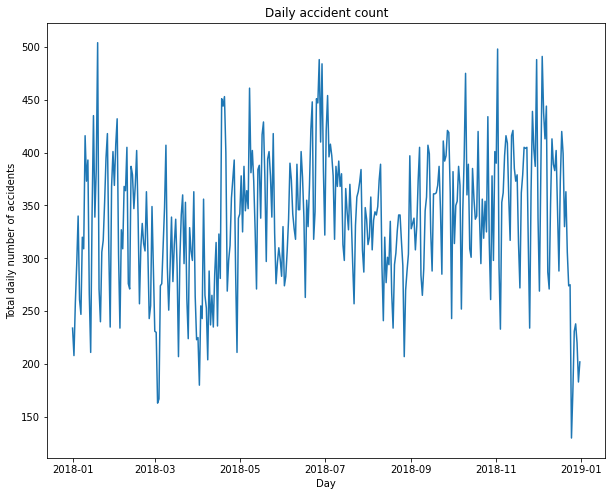

In [18]:
acc_daily = df.groupby("day").sum("Count")
acc_daily.drop(columns=["High_Winds","day_n","month_n",'hour'],inplace=True)

plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

## **2) Descriptive Statistics (EDA)**

### Train / Test Split

In [19]:
train_set,test_set = train_test_split(df,test_size=0.2, random_state=7)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

6832 train and 1708 test instances


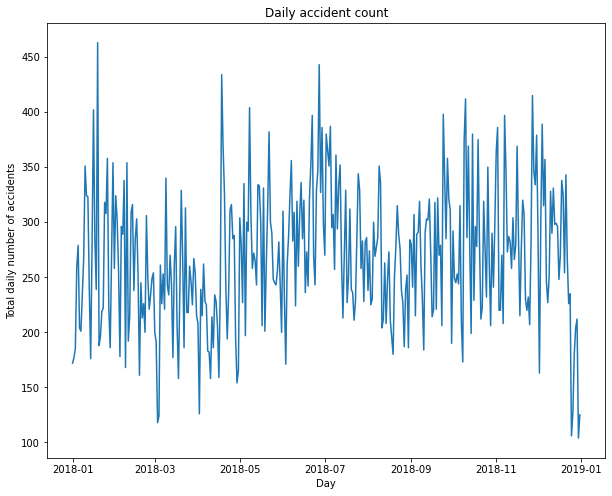

In [20]:
acc_daily_train = train_set.groupby("day").sum("Count")
acc_daily_train.drop(columns=["High_Winds","day_n","month_n",'hour'],inplace=True)
#acc_daily_train
plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily_train)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

In [21]:
print(f"As the graph shows the daily accident numbers swing between:", acc_daily_train["Count"].max(),"as maximum and",acc_daily_train["Count"].min(),"minimun." )

As the graph shows the daily accident numbers swing between: 463 as maximum and 104 minimun.


In [22]:
train_set.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'day_n', 'hour', 'month', 'month_n', 'Weekend', 'Season'],
      dtype='object')

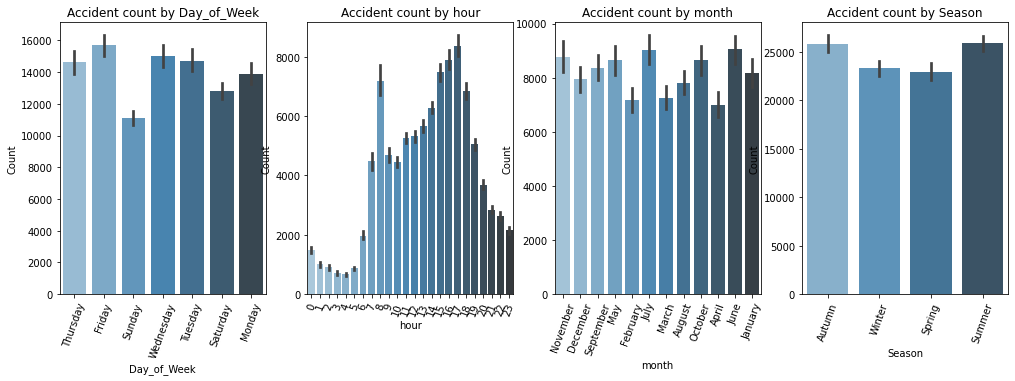

In [23]:
c = 1

fig = plt.figure(figsize=(17,5))

for i in df[["Day_of_Week",'hour','month','Season']]:
    plt.subplot(1, 4, c)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=train_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

Concerning the date and time of the data one can recognize that accidents are evenly distributed between the weekdays and only *sligthly* peak on Fridays and have a *slight* bottom on Sundays. 
Regarding the hours there is a more clear distribution towards the rush hour hours from 16:00 to 18:00 as well as in the mornings between 7:00 and 9:00. 

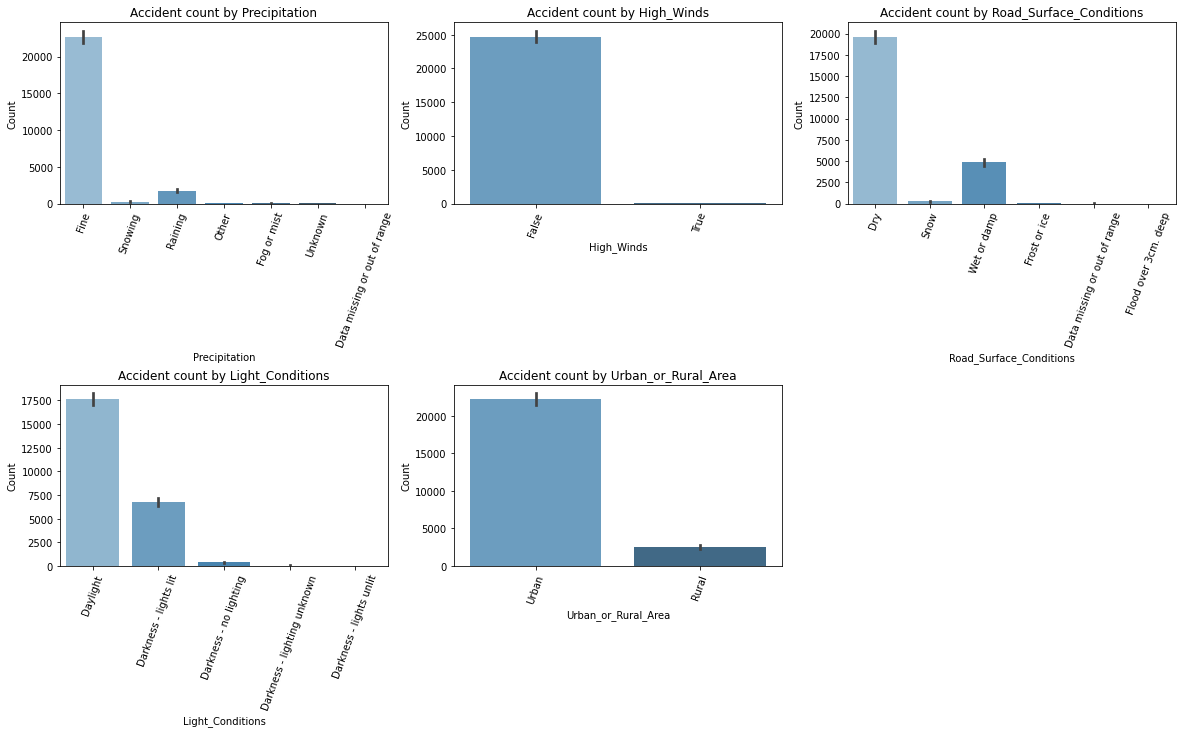

In [24]:
c = 1

fig = plt.figure(figsize=(20,10))

for i in df[['Precipitation',
       'High_Winds', 'Road_Surface_Conditions', 'Light_Conditions',
       'Urban_or_Rural_Area']]:
    plt.subplot(2, 3, c)
    plt.subplots_adjust(hspace=1)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=test_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

The graphs above all describe the features that are more related towards the features relating to the external circumstances of an accident. The first two graphs show that most accidents happen on fine precipation and without high winds. Furhtermore, graph 3 and 4 show that the majority occurs on dry conditions on daylight. Finally, there seems to be an overweight of accidents happen in urban areas. Also it feature values that are rare luke Darkness - lights unit oder frosty road conditions might consolidate into another variable value in the data preprocessing stage.

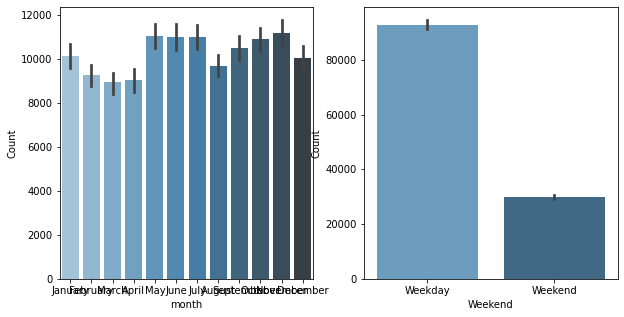

In [25]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.barplot(ax= axes[0], data=df, x='month', y='Count',estimator=sum,palette="Blues_d")
sns.barplot(ax=axes[1], data=df, x='Weekend', y='Count',estimator=sum,palette="Blues_d")
plt.show()

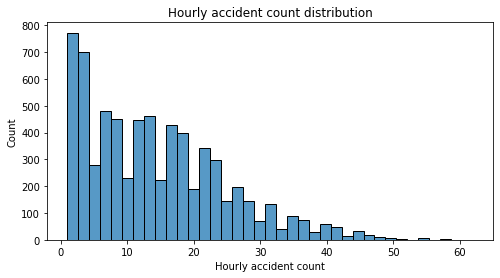

In [26]:
plt.figure(figsize=(8,4))
sns.histplot(data=train_set, x="Count")
plt.title("Hourly accident count distribution")
plt.xlabel("Hourly accident count")
plt.show()

## **3)** **Data Preprocessing**


In [27]:
train_set.isna().sum()

datetime                   0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
day                        0
day_n                      0
hour                       0
month                      0
month_n                    0
Weekend                    0
Season                     0
dtype: int64

In [28]:
test_set.isna().sum()

datetime                   0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
day                        0
day_n                      0
hour                       0
month                      0
month_n                    0
Weekend                    0
Season                     0
dtype: int64

In [29]:
for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Sunday       997
Saturday     996
Monday       979
Wednesday    970
Tuesday      968
Thursday     964
Friday       958
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           5989
Raining         655
Snowing          94
Unknown          39
Other            38
Fog or mist      17
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6773
True       59
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry                             5042
Wet or damp                     1643
Snow                              92
Frost or ice                      43
Data missing or out of range       8
Flood over 3cm. deep               4
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Daylight                       3841
Darkne

In [30]:
train_set.loc[train_set["Road_Surface_Conditions"].str.contains("Flood"), "Road_Surface_Conditions"] = "Wet or damp"

In [31]:
indexNames = train_set[(train_set['Precipitation'] == "Unknown") | (train_set['Precipitation'] == "Data missing or out of range") | (train_set["Road_Surface_Conditions"] == "Data missing or out of range")].index
train_set.drop(indexNames , inplace=True)


In [32]:
for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Saturday     992
Sunday       992
Monday       970
Wednesday    965
Thursday     963
Tuesday      957
Friday       953
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           5988
Raining         655
Snowing          94
Other            38
Fog or mist      17
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6733
True       59
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry             5027
Wet or damp     1631
Snow              92
Frost or ice      42
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Daylight                       3837
Darkness - lights lit          2450
Darkness - no lighting          405
Darkness - lighting unknown      76
Darkness - lights unlit          24
Name: Light_Conditio

Comparing the value counts of each feature, "Data that was out of range", "Unknown" was dropped from the dataset. Furthermore, 5 lines of data with the value "Flood over 3cm was attached to "wet or dump surface conditions".

In [33]:
cat_vals = ['Precipitation', 'High_Winds','Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'Weekend','Season']
vals = train_set[cat_vals]

In [34]:
categ = ['Precipitation','High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area','Weekend', 'Season']

In [35]:
lenc = LabelEncoder()

In [36]:
train_set_lenc = train_set.copy()

In [37]:
train_set_lenc[categ] = train_set_lenc[categ].apply(lenc.fit_transform)

In [38]:
train_set_lenc.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'day_n', 'hour', 'month', 'month_n', 'Weekend', 'Season'],
      dtype='object')

In [39]:
train_set_lenc = train_set_lenc[['datetime', 'Count', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'day_n', 'hour', 'month_n', 'Weekend', 'Season']]
train_set_lenc.head()

,datetime,Count,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day_n,hour,month_n,Weekend,Season
7601,2018-11-22 00:00:00,2,0,0,0,1,1,22,0,11,0,0
8454,2018-12-28 08:00:00,7,0,0,0,4,0,28,8,12,0,3
5983,2018-09-14 08:00:00,25,0,0,0,4,1,14,8,9,0,0
7525,2018-11-18 19:00:00,13,0,0,0,1,1,18,19,11,1,0
8253,2018-12-19 19:00:00,20,3,0,3,1,1,19,19,12,0,3


In [40]:
test_set_lenc = test_set
test_set_lenc[categ] = test_set_lenc[categ].apply(lenc.fit_transform)
test_set_lenc = test_set_lenc[['datetime', 'Count', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'day_n', 'hour', 'month_n', 'Weekend', 'Season']]
test_set_lenc.head()

,datetime,Count,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day_n,hour,month_n,Weekend,Season
805,2018-02-04 16:00:00,13,1,0,1,4,1,4,16,2,1,3
1086,2018-02-16 19:00:00,30,1,0,1,1,1,16,19,2,0,3
6392,2018-10-01 17:00:00,32,1,0,1,4,1,1,17,10,0,0
7090,2018-10-31 06:00:00,3,1,0,1,3,0,31,6,10,0,0
743,2018-02-02 01:00:00,1,5,1,4,3,1,2,1,2,0,3


## **4) Feature construction & selection**

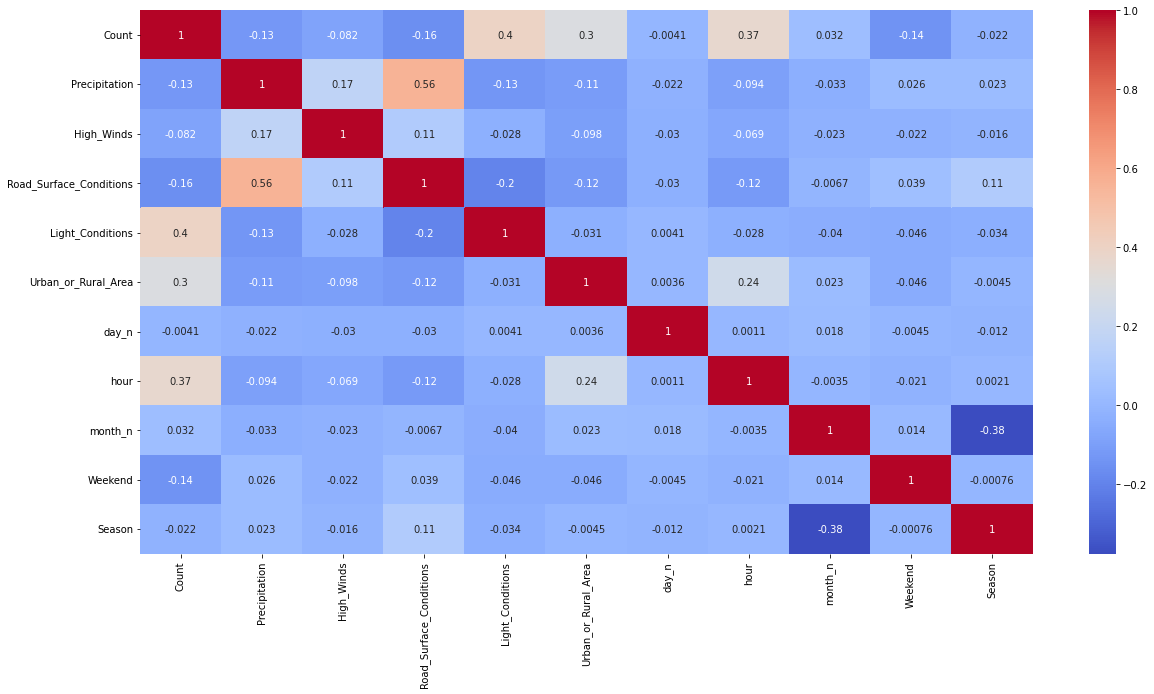

In [41]:
corr_mat_lenc = train_set_lenc.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat_lenc, annot=True, cmap="coolwarm")
plt.show()

The correlation heatmap shows that there seems to be no multicollinearity between the features, only month and season seem to have multicollinearity as these values are close to -1. Moreover, considering the correlation between "Count" and the features, "High wind", "Season", "day_n" and "month_n" will not be considered as features of the model.

## **5) Baseline Model**

In [42]:
median_accident_count = train_set_lenc["Count"].median()
print(f"There are:", median_accident_count,"accidents per hour.")

There are: 13.0 accidents per hour.


In [43]:
yhat =  np.full((train_set_lenc.shape[0],1), median_accident_count)

In [44]:
baseline_mse = mean_squared_error(train_set_lenc["Count"],yhat)
print(f"The baseline MSE is:",baseline_mse)

baseline_rmse = np.sqrt(baseline_mse)
print(f"The basline RMSE is:",baseline_rmse)

The baseline MSE is: 112.41107184923439
The basline RMSE is: 10.602408775803468


The RMSE of 10.4 indicates the amount by which the baseline gets hourly accident count wrong which is quite a big amount comparing to the mean of 13 accidents per hour. This suggests this is a difficult problem to solve.

### **Seperating X and y variables**

In [45]:
X_train = train_set_lenc[["Precipitation","Road_Surface_Conditions", "Light_Conditions","Urban_or_Rural_Area","hour","Weekend"]]
X_test =  test_set_lenc[["Precipitation","Road_Surface_Conditions", "Light_Conditions","Urban_or_Rural_Area","hour","Weekend"]]

In [105]:
y_train = train_set_lenc["Count"]
y_test= pd.DataFrame(test_set_lenc["Count"].reset_index(drop=True))

## **6) Random Forest Regression Model**


In [106]:
rfr = RandomForestRegressor(n_estimators=10)

In [107]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [108]:
y_pred_rfr = rfr.predict(X_test)
y_pred_rfr

array([15.9072952 , 18.66981726, 32.32143277, ...,  2.9       ,
        4.21007604, 32.32143277])

In [109]:
rfr_mse = mean_squared_error(y_test, y_pred_rfr)
rfr_mse

31.527715737017584

In [110]:
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse

5.614954651376767

In [52]:
cv_scores_rfr = cross_val_score(rfr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

In [101]:
rmse_cv_scores_rfr = np.sqrt(-cv_scores_rfr)

print(f"Scores:",rmse_cv_scores_rfr)
print(f"Scores mean:",rmse_cv_scores_rfr.mean())
print(f"Scores std:",rmse_cv_scores_rfr.std())
print(f"Scores min:",rmse_cv_scores_rfr.min())
print(f"Scores max:",rmse_cv_scores_rfr.max())

Scores: [5.3310807  5.18403314 5.23589286 5.49426354 5.70491902 5.45697718
 5.38083812 5.83063635 5.79772985 5.28744011]
Scores mean: 5.470381086316699
Scores std: 0.2214879164829895
Scores min: 5.184033137937629
Scores max: 5.830636351045748


In [54]:
param_grid_rfr = [
                {'n_estimators':[3,5,10,30,50], 'max_depth':[2,4,6,8,None]}
]

In [55]:
grid_search_rfr = GridSearchCV(rfr,param_grid_rfr,cv=10, scoring='neg_mean_squared_error', return_train_score=True)


In [56]:
grid_search_rfr.fit(X_train,y_train)
cv_rfr_df = pd.DataFrame(grid_search_rfr.cv_results_)
cv_rfr_df[["params","mean_test_score","mean_train_score"]].head()

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'n_estimators': 3}",-54.717384,-54.686697
1,"{'max_depth': 2, 'n_estimators': 5}",-54.737311,-54.684049
2,"{'max_depth': 2, 'n_estimators': 10}",-54.720595,-54.683378
3,"{'max_depth': 2, 'n_estimators': 30}",-54.711013,-54.681051
4,"{'max_depth': 2, 'n_estimators': 50}",-54.725759,-54.682149


In [57]:
grid_search_rfr.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=30)

In [58]:
np.sqrt(-grid_search_rfr.best_score_)

5.412605125153232

In [59]:
feature_importances_rfr = grid_search_rfr.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances_rfr,X_train.columns), reverse=True):
  print(f"{v}: {k}")

hour: 0.8914509780082872
Weekend: 0.0725875791404995
Urban_or_Rural_Area: 0.012618174489686126
Precipitation: 0.008686960945931467
Light_Conditions: 0.008218896784168478
Road_Surface_Conditions: 0.0064374106314271755


In [60]:
best_rfr = grid_search_rfr.best_estimator_
yhat_rfr = best_rfr.predict(X_test)

final_mse_rfr = mean_squared_error(y_test, yhat_rfr)
final_rmse_rfr = np.sqrt(final_mse_rfr)
final_rmse_rfr

5.2747294040100625

Comparing the RMSE from the cross validated training data of 5.35 and the RMSE of the test data, one can conclude that the model's quality decreases with unseen test data.

In [61]:
yhat_rfr = pd.DataFrame(yhat_rfr)

rfr_eval = []
rfr_eval = pd.DataFrame(columns=["y_test","y_hat"])
rfr_eval["y_test"] = y_test["Count"]
rfr_eval["y_hat"] = yhat_rfr[0]


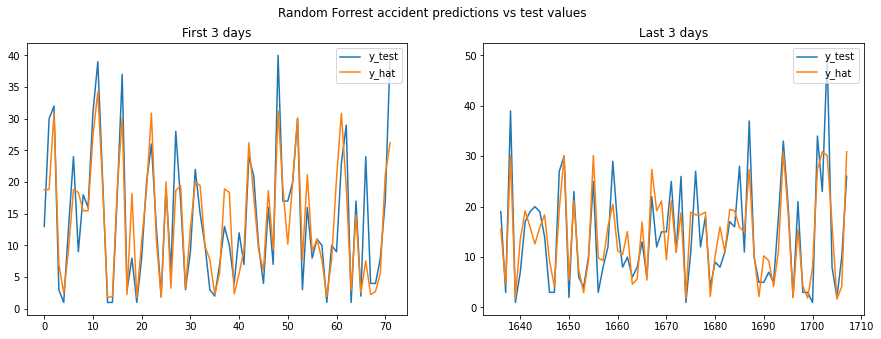

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Random Forrest accident predictions vs test values')
ax1.plot(rfr_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=rfr_eval.columns,loc="upper right")
ax2.plot(rfr_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=rfr_eval.columns,loc="upper right")
plt.show()

## **7) Decision Tree Regressor Model**


In [63]:
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=None)

In [64]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1)

In [65]:
y_pred_dt = dt.predict(X_test)

In [111]:
mse_dt = mean_squared_error(y_test,y_pred_dt)
print(f" The mean squared error for Decision Tree Regressor is:", mse_dt)


 The mean squared error for Decision Tree Regressor is: 43.12473748226543


In [67]:
rmse_dt = np.sqrt(mse_dt)
print(f"The root means squared error for the Decision Tree Model is:", rmse_dt)

The root means squared error for the Decision Tree Model is: 6.566942780492718


In [68]:
cv_scores_dt = cross_val_score(dt,X_train, y_train,scoring="neg_mean_squared_error",cv=10)

In [69]:
rmse_cv_scores_dt = np.sqrt(-cv_scores_dt)
print(f"Scores:",rmse_cv_scores_dt)
print(f"Scores mean:",rmse_cv_scores_dt.mean())
print(f"Scores std:",rmse_cv_scores_dt.std())
print(f"Scores min:",rmse_cv_scores_dt.min())
print(f"Scores max:",rmse_cv_scores_dt.max())

Scores: [7.01348129 6.90353943 6.69951716 7.28395529 7.15419014 6.71335676
 6.45584003 7.2055284  7.16957399 6.80819052]
Scores mean: 6.9407173013475285
Scores std: 0.2559491558993291
Scores min: 6.455840029760216
Scores max: 7.283955285376677


In [70]:
param_grid_dt = [
                {'max_depth':[4,8,10,30,50], 'min_samples_leaf':[2,4,6,8]}
]

In [71]:
grid_search_dt = GridSearchCV(dt,param_grid_dt,cv=10, scoring='neg_mean_squared_error', return_train_score=True)


In [72]:
grid_search_dt.fit(X_train,y_train)
cv_dt_df = pd.DataFrame(grid_search_dt.cv_results_)
cv_dt_df[["params","mean_test_score","mean_train_score"]].head()

,params,mean_test_score,mean_train_score
0,"{'max_depth': 4, 'min_samples_leaf': 2}",-41.793519,-41.807027
1,"{'max_depth': 4, 'min_samples_leaf': 4}",-41.794729,-41.807209
2,"{'max_depth': 4, 'min_samples_leaf': 6}",-41.794729,-41.807209
3,"{'max_depth': 4, 'min_samples_leaf': 8}",-41.794729,-41.807209
4,"{'max_depth': 8, 'min_samples_leaf': 2}",-29.695742,-27.790954


In [73]:
grid_search_dt.best_params_

{'max_depth': 8, 'min_samples_leaf': 6}

In [74]:
np.sqrt(-grid_search_dt.best_score_)

5.4340680643551815

In [75]:
feature_importances_dt = grid_search_dt.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances_dt,X_train.columns), reverse=True):
  print(f"{v}: {k}")

hour: 0.8967895940011505
Weekend: 0.07397567697529636
Urban_or_Rural_Area: 0.012090401416510839
Light_Conditions: 0.007362076761192236
Precipitation: 0.005033323442694784
Road_Surface_Conditions: 0.004748927403155266


In [76]:
best_dt = grid_search_dt.best_estimator_
yhat_dt = best_dt.predict(X_test)

final_mse_dt = mean_squared_error(y_test, yhat_dt)
final_rmse_dt = np.sqrt(final_mse_dt)
final_rmse_dt

5.254749751325836

In [77]:
yhat_dt = pd.DataFrame(yhat_dt)

In [78]:
dt_eval = []
dt_eval = pd.DataFrame(columns=["y_test","y_hat_dt"])
dt_eval["y_test"] = y_test["Count"]
dt_eval["y_hat_dt"] = yhat_dt[0]

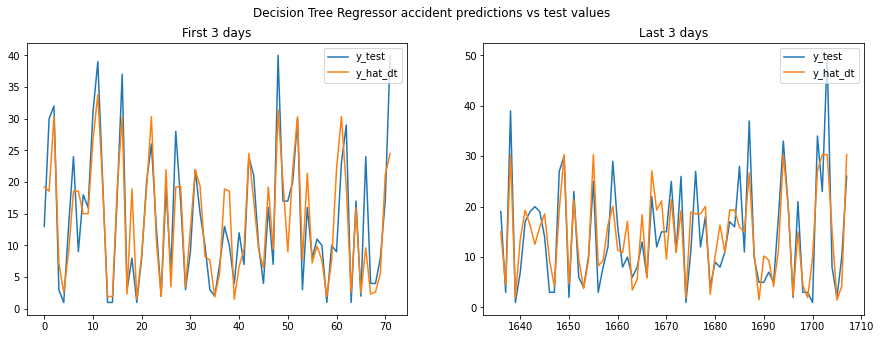

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Decision Tree Regressor accident predictions vs test values')
ax1.plot(dt_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=dt_eval.columns,loc="upper right")
ax2.plot(dt_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=dt_eval.columns,loc="upper right")
plt.show()

## **8) XG Boost Model**

In [80]:
xgbr = XGBRegressor(verbosity=0)

In [89]:
xgbr.fit(X_train, y_train)

XGBRegressor(verbosity=0)

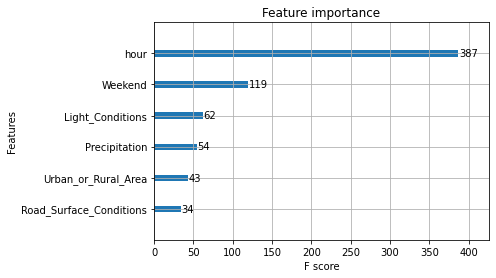

In [112]:
xgb.plot_importance(xgbr, ax=plt.gca())

In [113]:
score = xgbr.score(X_train, y_train)
score

0.7278942048712223

In [117]:
y_pred_xgbr = xgbr.predict(X_test)
y_pred_xgbr

array([20.863594 , 16.88613  , 31.53646  , ...,  1.5661111,  3.545884 ,
       31.53646  ], dtype=float32)

In [119]:
mse_xgbr = mean_squared_error(y_test,y_pred_xgbr)
print(f" The mean squared error for XG Boost regressor is:", mse_xgbr)

 The mean squared error for XG Boost regressor is: 29.372993719638735


In [121]:
rmse_xgbr = np.sqrt(mse_xgbr)
print(f"The root mean squared error for the XG Boost regressor model is:", rmse_dt)

The root mean squared error for the XG Boost regressor model is: 6.566942780492718


In [122]:
cv_scores_xgbr = cross_val_score(xgbr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

In [84]:
rmse_cv_scores_xgbr = np.sqrt(-cv_scores_xgbr)
print(f"Scores:",rmse_cv_scores_xgbr)
print(f"Scores mean:",rmse_cv_scores_xgbr.mean())
print(f"Scores std:",rmse_cv_scores_xgbr.std())
print(f"Scores min:",rmse_cv_scores_xgbr.min())
print(f"Scores max:",rmse_cv_scores_xgbr.max())

Scores: [5.41254347 5.36608113 5.25479896 5.65181518 5.71792287 5.46586457
 5.46187875 5.95392886 5.67888038 5.3330284 ]
Scores mean: 5.529674257143091
Scores std: 0.20395750577548155
Scores min: 5.25479895944637
Scores max: 5.953928862241391


In [137]:
param_grid_xgbr = [
                {'n_estimators:': [50,100,200], 'max_depth':[2,3,5,10,15]}
]

In [138]:
grid_search_xgbr = GridSearchCV(xgbr,param_grid_xgbr,cv=10, scoring='neg_mean_squared_error', return_train_score=True)

In [142]:
grid_search_xgbr.fit(X_train,y_train)

In [ ]:
cv_xgbr_df = pd.DataFrame(grid_search_xgbr.cv_results_)
cv_xgbr_df[["params","mean_test_score","mean_train_score"]].head()

## **9) Discussion of evaluation results**

## **10) Possible future improvements**